In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import csv
import pandas as pd
from sklearn.cluster import KMeans
from numpy import array
import time
import warnings
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

pd.set_option("display.max_rows",250)
pd.set_option("display.max_columns",250)

In [40]:
df = pd.DataFrame.from_csv("./results.csv")

In [41]:
df.head()

,MAC,nbAPConnected,coToAdmin,coToAcademic,coToSocial,coToLibrary,coToResidential,only Academic or Admin,is Night,is Weekend
0,0040961e58be,19,1,1,0,1,1,0,0.0,0.0
1,nothing,8,1,1,0,1,0,0,0.0,0.0
2,00601db0635a,2,1,0,0,1,0,0,0.0,0.0
3,00409699dfba,10,1,1,0,1,0,0,0.0,0.0
4,004096daa8fe,6,0,1,0,0,0,1,0.0,0.0


In [42]:
# Select only first MAC addresses, those implied in connexions with an AP
df = df[:424]
df = df.drop(df.index[381], inplace=False)
len(df)

423

In [43]:
df.columns

Index([u'MAC', u'nbAPConnected', u'coToAdmin', u'coToAcademic', u'coToSocial',
       u'coToLibrary', u'coToResidential', u'only Academic or Admin',
       u'is Night', u'is Weekend'],
      dtype='object')

In [44]:

df1 = df[["nbAPConnected","only Academic or Admin","coToAdmin",
          "coToAcademic","coToSocial","coToLibrary","coToResidential","is Night","is Weekend"]]


In [45]:
X = df1.values
X.shape

(423L, 9L)

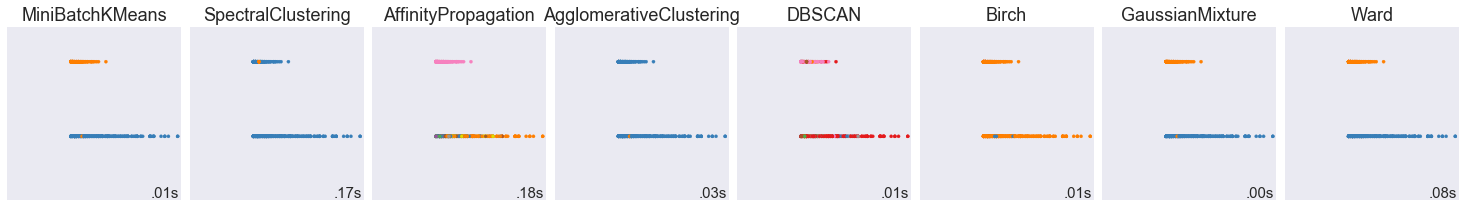

In [52]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 2.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 2}

params = default_base.copy()


X =df1.values

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity)
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
    affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], preference=params['preference'])
average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock",
    n_clusters=params['n_clusters'], connectivity=connectivity)
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full')

clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('SpectralClustering', spectral),
    ('AffinityPropagation', affinity_propagation),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm),
    ('Ward', ward)
)


for name, algorithm in clustering_algorithms:
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    df1[name]=y_pred
    plt.subplot(1, len(clustering_algorithms), plot_num)
    plt.title(name, size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1

plt.show()

In [67]:
pd.options.display.float_format = '{:,.1f}'.format
n_clusters = 2
selected_clustering_algorithms = ('MiniBatchKMeans', 'SpectralClustering')
for algo in selected_clustering_algorithms:
    
    d= {x:df1[algo].tolist().count(x) for x in df1[algo].tolist()}
    print "***************************************************"
    print algo + ":  "+ str(d) + "\n" 
    
    for i in range(n_clusters) :
        print "      -------------"
        print "      | cluster " + str(i+1) + " |"
        print "      -------------"
        print df1[df1[algo]==i][columns].mean()
        print "\n"
    print "\n\n"

***************************************************
MiniBatchKMeans:  {0: 291, 1: 132}

      -------------
      | cluster 1 |
      -------------
nbAPConnected            17.8
only Academic or Admin    0.0
is Night                  0.9
is Weekend                0.7
dtype: float64


      -------------
      | cluster 2 |
      -------------
nbAPConnected            4.3
only Academic or Admin   1.0
is Night                 0.7
is Weekend               0.6
dtype: float64





***************************************************
SpectralClustering:  {0: 412, 1: 11}

      -------------
      | cluster 1 |
      -------------
nbAPConnected            13.9
only Academic or Admin    0.3
is Night                  0.9
is Weekend                0.7
dtype: float64


      -------------
      | cluster 2 |
      -------------
nbAPConnected            4.0
only Academic or Admin   1.0
is Night                 0.0
is Weekend               0.0
dtype: float64







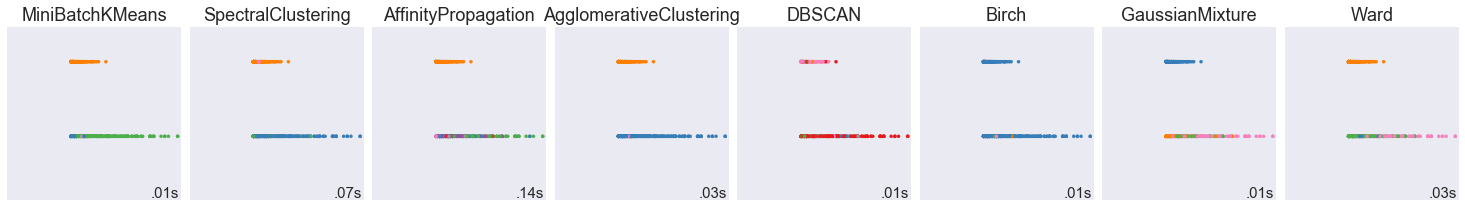

In [68]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 2.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 4}

params = default_base.copy()


X =df1.values

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity)
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
    affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], preference=params['preference'])
average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock",
    n_clusters=params['n_clusters'], connectivity=connectivity)
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full')

clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('SpectralClustering', spectral),
    ('AffinityPropagation', affinity_propagation),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm),
    ('Ward', ward)
)


for name, algorithm in clustering_algorithms:
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    df1[name]=y_pred
    plt.subplot(1, len(clustering_algorithms), plot_num)
    plt.title(name, size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1

plt.show()

In [47]:
df1

,nbAPConnected,only Academic or Admin,coToAdmin,coToAcademic,coToSocial,coToLibrary,coToResidential,is Night,is Weekend,MiniBatchKMeans,SpectralClustering,AffinityPropagation,AgglomerativeClustering,DBSCAN,Birch,GaussianMixture,Ward
0,19,0,1,1,0,1,1,0.0,0.0,2,0,5,0,0,0,1,2
1,8,0,1,1,0,1,0,0.0,0.0,0,0,0,0,1,0,3,0
2,2,0,1,0,0,1,0,0.0,0.0,0,0,4,0,2,0,2,0
3,10,0,1,1,0,1,0,0.0,0.0,0,0,0,0,1,0,3,0
4,6,1,0,1,0,0,0,0.0,0.0,1,1,2,1,3,0,0,3
5,4,1,0,1,0,0,0,0.0,0.0,1,2,2,1,3,0,0,3
6,25,0,1,1,0,1,1,0.0,0.0,2,0,5,0,0,0,1,2
7,107,0,1,1,1,1,1,0.0,0.0,2,0,5,0,-1,0,1,2
8,106,0,1,1,1,1,1,0.0,0.0,2,0,5,0,-1,0,1,2
9,155,0,1,1,1,1,1,0.0,0.0,2,0,5,0,-1,0,1,2


In [48]:

df1["MiniBatchKMeans"].mean()
d= {x:df1["MiniBatchKMeans"].tolist().count(x) for x in df1["MiniBatchKMeans"].tolist()}
print d

{0: 143, 1: 131, 2: 131, 3: 18}


In [55]:
columns = [u'nbAPConnected', u'only Academic or Admin', u'is Night', u'is Weekend']

In [56]:
print columns

[u'nbAPConnected', u'only Academic or Admin', u'is Night', u'is Weekend']


In [69]:
n_clusters = 4
selected_clustering_algorithms = ('SpectralClustering','GaussianMixture','Ward')
for algo in selected_clustering_algorithms:
    
    d= {x:df1[algo].tolist().count(x) for x in df1[algo].tolist()}
    print "***************************************************"
    print algo + ":  "+ str(d) + "\n" 
    
    for i in range(n_clusters) :
        print "      -------------"
        print "      | cluster " + str(i+1) + " |"
        print "      -------------"
        print df1[df1[algo]==i][columns].mean()
        print "\n"
    print "\n\n"

***************************************************
SpectralClustering:  {0: 251, 1: 120, 2: 41, 3: 11}

      -------------
      | cluster 1 |
      -------------
nbAPConnected            19.1
only Academic or Admin    0.0
is Night                  1.3
is Weekend                1.0
dtype: float64


      -------------
      | cluster 2 |
      -------------
nbAPConnected            4.3
only Academic or Admin   1.0
is Night                 0.2
is Weekend               0.1
dtype: float64


      -------------
      | cluster 3 |
      -------------
nbAPConnected            9.7
only Academic or Admin   0.0
is Night                 0.3
is Weekend               0.3
dtype: float64


      -------------
      | cluster 4 |
      -------------
nbAPConnected            4.0
only Academic or Admin   1.0
is Night                 0.0
is Weekend               0.0
dtype: float64





***************************************************
GaussianMixture:  {0L: 131, 1L: 86, 2L: 46, 3L: 160}

      ----

SpectralClustering:  {1: 317, 2: 10, 3: 85, 4: 11}
cluster 1, 3 : widely connected, everywhere, can be at night and weekend : student ?    
cluster 2: only on academic, reraly on night or weekend : prof and postdocs ?
cluster 4: poorly connected, only academic, never weekend nor night  : some prof and administrative staff ?

GaussianMixture:  {1: 55, 2: 130, 3: 131, 4: 107}
cluster 1 : poor connected, only academic or admin, very infrequent on night or weekend : prof ?
cluster 2 : everywhere, sometimes night or weekend : students ?
cluster 3 : connected everywhere, night or we : student, internal ?
cluster 4 : same but no night or we : external students ?

Ward:  {1: 135, 2: 131, 3: 103, 4: 54}
cluster 1 :very often at night and weekend, everywhere : students, internal ?
cluster 2 : only academic or admin, sometimes night or we : prof ?
cluster 3, 4 : (very) widely connected, everywhere, but not often at night : students, external ?